In [ ]:
pip install -q keras-nlp

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow import keras
import keras_nlp
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageFile, UnidentifiedImageError

2025-04-19 05:02:51.673180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745038971.844203      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745038971.895149      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = pd.read_csv('/kaggle/input/multioff-dataset/MultiOFF/Split Dataset/Training_meme_dataset.csv')
img_folder = '/kaggle/input/multioff-dataset/MultiOFF/Labelled Images'
target_shape = (224, 224)

df_train['label'] = df_train['label'].replace({'offensive': 1,'Non-offensiv': 0})

for index, row in df_train.iterrows():
    if pd.isna(row['sentence']):
        df_train.at[index, 'sentence'] = '.'

/tmp/ipykernel_31/575207717.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['label'] = df_train['label'].replace({'offensive': 1,'Non-offensiv': 0})


In [3]:
df_train['label'].value_counts()

label
0    258
1    187
Name: count, dtype: int64

In [4]:
df_val = pd.read_csv('/kaggle/input/multioff-dataset/MultiOFF/Split Dataset/Validation_meme_dataset.csv')
df_val['label'] = df_val['label'].replace({'offensive': 1,'Non-offensiv': 0})
for index, row in df_val.iterrows():
    if pd.isna(row['sentence']):
        df_val.at[index, 'sentence'] = '.'

/tmp/ipykernel_31/1410767554.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_val['label'] = df_val['label'].replace({'offensive': 1,'Non-offensiv': 0})


In [5]:
df_val['label'].value_counts()

label
0    91
1    58
Name: count, dtype: int64

In [6]:
df = pd.concat([df_train, df_val], axis=0).reset_index(drop=True)

In [7]:
df['label'].value_counts()

label
0    349
1    245
Name: count, dtype: int64

In [8]:
grouped = df.groupby('label')
min_size = grouped.size().max()
min_size = 500

In [9]:
df = grouped.apply(lambda x: x.sample(min_size, replace=True)).reset_index(drop=True)

/tmp/ipykernel_31/870976926.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(lambda x: x.sample(min_size, replace=True)).reset_index(drop=True)


In [10]:
#X_train_txt
X_train_txt = df['sentence']
X_train_txt = X_train_txt.tolist()
X_train_txt = [s.replace('\n', ' ') for s in X_train_txt]

In [11]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
images = []
#X_train_image
for index,row in df.iterrows():
    img_path = os.path.join(img_folder, str(row['image_name']))
    image = Image.open(img_path) 
    image = image.convert('RGB')    
    image = image.resize(target_shape)
    image_array = np.array(image)
    images.append(image)

In [12]:
len(df)

1000

In [13]:
X_train_img = np.array(images)

In [14]:
len(X_train_img)

1000

In [15]:
Y_train = df['label']
print(Y_train.value_counts())
Y_train = np.array(Y_train, dtype=np.int32)

label
0    500
1    500
Name: count, dtype: int64


In [16]:
len(X_train_txt)

1000

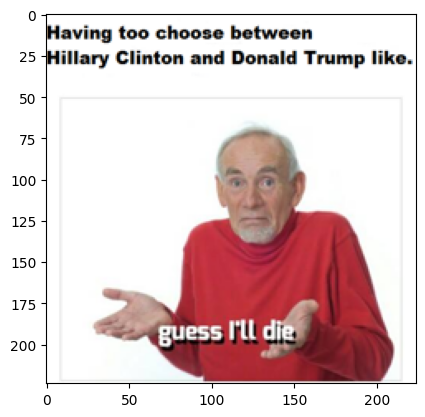

In [17]:
plt.imshow(X_train_img[200])

In [18]:
X_train_txt[200]

'Having too choose between Hillary Clinton and Donald Trump like . guess Ill d '

In [19]:
len(Y_train)

1000

In [20]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

# Load model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [21]:
def get_caption(image):
    inputs = processor(images=image, return_tensors="pt").to(device)
    out = blip.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

In [22]:
train_cap = [get_caption(image) for image in images]

In [23]:
train_cap[200]

'a close up of a person holding a hand out with a caption'

In [24]:
df_test = pd.read_csv('/kaggle/input/multioff-dataset/MultiOFF/Split Dataset/Testing_meme_dataset.csv')
df_test['label'] = df_test['label'].replace({'offensive': 1, 'Non-offensiv': 0})

for index, row in df_test.iterrows():
    if pd.isna(row['sentence']):
        df_test.at[index, 'sentence'] = '.'

/tmp/ipykernel_31/769595000.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['label'] = df_test['label'].replace({'offensive': 1, 'Non-offensiv': 0})


In [25]:
df_test['label'].value_counts()

label
0    91
1    58
Name: count, dtype: int64

In [26]:
X_test_txt = df_test['sentence']
X_test_txt = X_test_txt.tolist()
X_test_txt = [s.replace('\n', ' ') for s in X_test_txt]

In [28]:
len(X_test_txt)

149

In [29]:
images_test = []
for index,row in df_test.iterrows():
    img_path = os.path.join(img_folder, str(row['image_name']))
    image = Image.open(img_path)
    image = image.convert('RGB')    
    image = image.resize(target_shape)
    image_array = np.array(image)
    images_test.append(image)

In [30]:
X_test_img = np.array(images_test)

In [31]:
len(X_test_img)

149

In [32]:
Y_test = df_test['label']

In [33]:
len(Y_test)

149

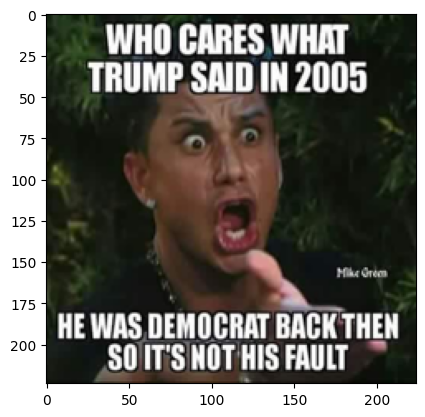

In [35]:
plt.imshow(X_test_img[52])

In [36]:
X_test_txt[52]

"WHO CARES WHAT TRUMP SANDIN 2005 Mike Green HE WAS DEMOCRAT BACK THEN SO IT 'S NOT HIS FAULT "

In [37]:
test_cap = [get_caption(image) for image in images_test]

In [38]:
test_cap[52]

'arafed image of a man with a funny expression on his face'

In [65]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense, Bidirectional, Reshape, GlobalAveragePooling2D, Embedding
from keras.optimizers import Adam
from tensorflow.keras import regularizers

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
max_len = 32

def preprocess_texts(texts):
    tokenizer.fit_on_texts(texts)
    seqs = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')
    return padded

In [66]:
embedding_dim = 32             

input_shape = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_shape)
bilstm_1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
dropout1 = Dropout(0.5)(bilstm_1)
bilstm_2 = Bidirectional(LSTM(32, return_sequences=False))(dropout1)
dropout2 = Dropout(0.5)(bilstm_2)

cap_features = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4), name='caption_features')(dropout2)

model_cap = Model(inputs=input_shape, outputs=cap_features)
model_cap.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 32, 32)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 32, 128)             │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ caption_features (Dense)             │ (None, 64)                  │           4,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 415,040 (1.58 MB)

 Trainable params: 415,040 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
albert_preprocessor = keras_nlp.models.AlbertPreprocessor.from_preset(
    "albert_large_en_uncased",
    sequence_length=32,
)
# Pretrained classifier.
albert = keras_nlp.models.AlbertClassifier.from_preset(
    "albert_large_en_uncased",
    preprocessor=albert_preprocessor,
    num_classes=2
)
albert.backbone.trainable = False

Mounting files to /kaggle/input/albert/keras/albert_large_en_uncased/2...


In [67]:
output = albert.backbone.pooled_dense.output
reshaped_output = Reshape((1,1024), name='reshape_layer')(output)
bilstm_layer1 = Bidirectional(LSTM(64, return_sequences=True), name='lstm_layer1')(reshaped_output)
dropout_layer1 = Dropout(0.5, name='dropout_layer1')(bilstm_layer1)
bilstm_layer2 = Bidirectional(LSTM(32, return_sequences=False), name='lstm_layer2')(dropout_layer1)
dropout_layer2 = Dropout(0.5, name='dropout_layer2')(bilstm_layer2)
txt_features = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4), name='text_features')(dropout_layer2)

model_txt = Model(inputs=albert.input, outputs=txt_features)
model_txt.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding           │ (None, None, 128)      │      3,840,000 │ token_ids[0][0]        │
│ (ReversibleEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding        │ (None, None, 128)      │         65,536 │ token_embedding[0][0]  │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_embedding         │ (None, None, 128)      │            256 │ segment_ids[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings_add (Add)      │ (None, None, 128)      │              0 │ token_embedding[0][0], │
│                           │                        │                │ position_embedding[0]… │
│                           │                        │                │ segment_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings_layer_norm     │ (None, None, 128)      │            256 │ embeddings_add[0][0]   │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings_dropout        │ (None, None, 128)      │              0 │ embeddings_layer_norm… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_projection      │ (None, None, 1024)     │        132,096 │ embeddings_dropout[0]… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_0_inner_layer_0     │ (None, None, 1024)     │     12,596,224 │ embedding_projection[… │
│ (TransformerEncoder)      │                        │                │ padding_mask[0][0],    │
│                           │                        │                │ group_0_inner_layer_0… │
│                           │                        │                │ padding_mask[0][0],    │
│                           │                        │                │ group_0_inner_layer_0… │
│                           │                        │                │ padding_mask[0][0],    │
│                           │                        │                │ group_0_inner_layer_0… │
│                           │                        │                │ padding_mask[0][0],    │
│                           │                        │                │ group_0_inner_layer_0… │
│                           │                        │                │ padding_mask[0][0],    │
│                      

 Total params: 18,286,912 (69.76 MB)

 Trainable params: 602,944 (2.30 MB)

 Non-trainable params: 17,683,968 (67.46 MB)

In [68]:
vgg11_preprocessor = keras_nlp.models.ImageClassifierPreprocessor.from_preset(
    "vgg_11_imagenet",
)
vgg11 = keras_nlp.models.ImageClassifier.from_preset(
    "vgg_11_imagenet",
    preprocessor=vgg11_preprocessor,
    image_shape = (224, 224, 3),
    num_classes=2
)
for layer in vgg11.backbone.layers:
    layer.trainable = False
backbone_output = vgg11.backbone.output
x = GlobalAveragePooling2D(name='global_average_pooling2d')(backbone_output)
# Image features
img_features = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4), name="image_features")(x)

model_img = Model(inputs=vgg11.input, outputs=img_features)
model_img.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ image_features (Dense)               │ (None, 64)                  │          32,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,253,312 (35.30 MB)

 Trainable params: 32,832 (128.25 KB)

 Non-trainable params: 9,220,480 (35.17 MB)

In [69]:
# Input layers
text_input = model_txt.input
img_input = model_img.input
cap_input = model_cap.input
# Concatenate features
combined_features = keras.layers.concatenate([txt_features, img_features, cap_features], name='Concatenated_features')

dropout = Dropout(0.5, name='dropout_layer_end')(combined_features)
pre_pred = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(1e-4), name='dense_layer_end')(dropout)

# Final prediction layer
predictions = Dense(2, activation='softmax', name='pred_layer')(pre_pred)

# Final model
model = Model(inputs=[text_input, img_input, cap_input], outputs=predictions)

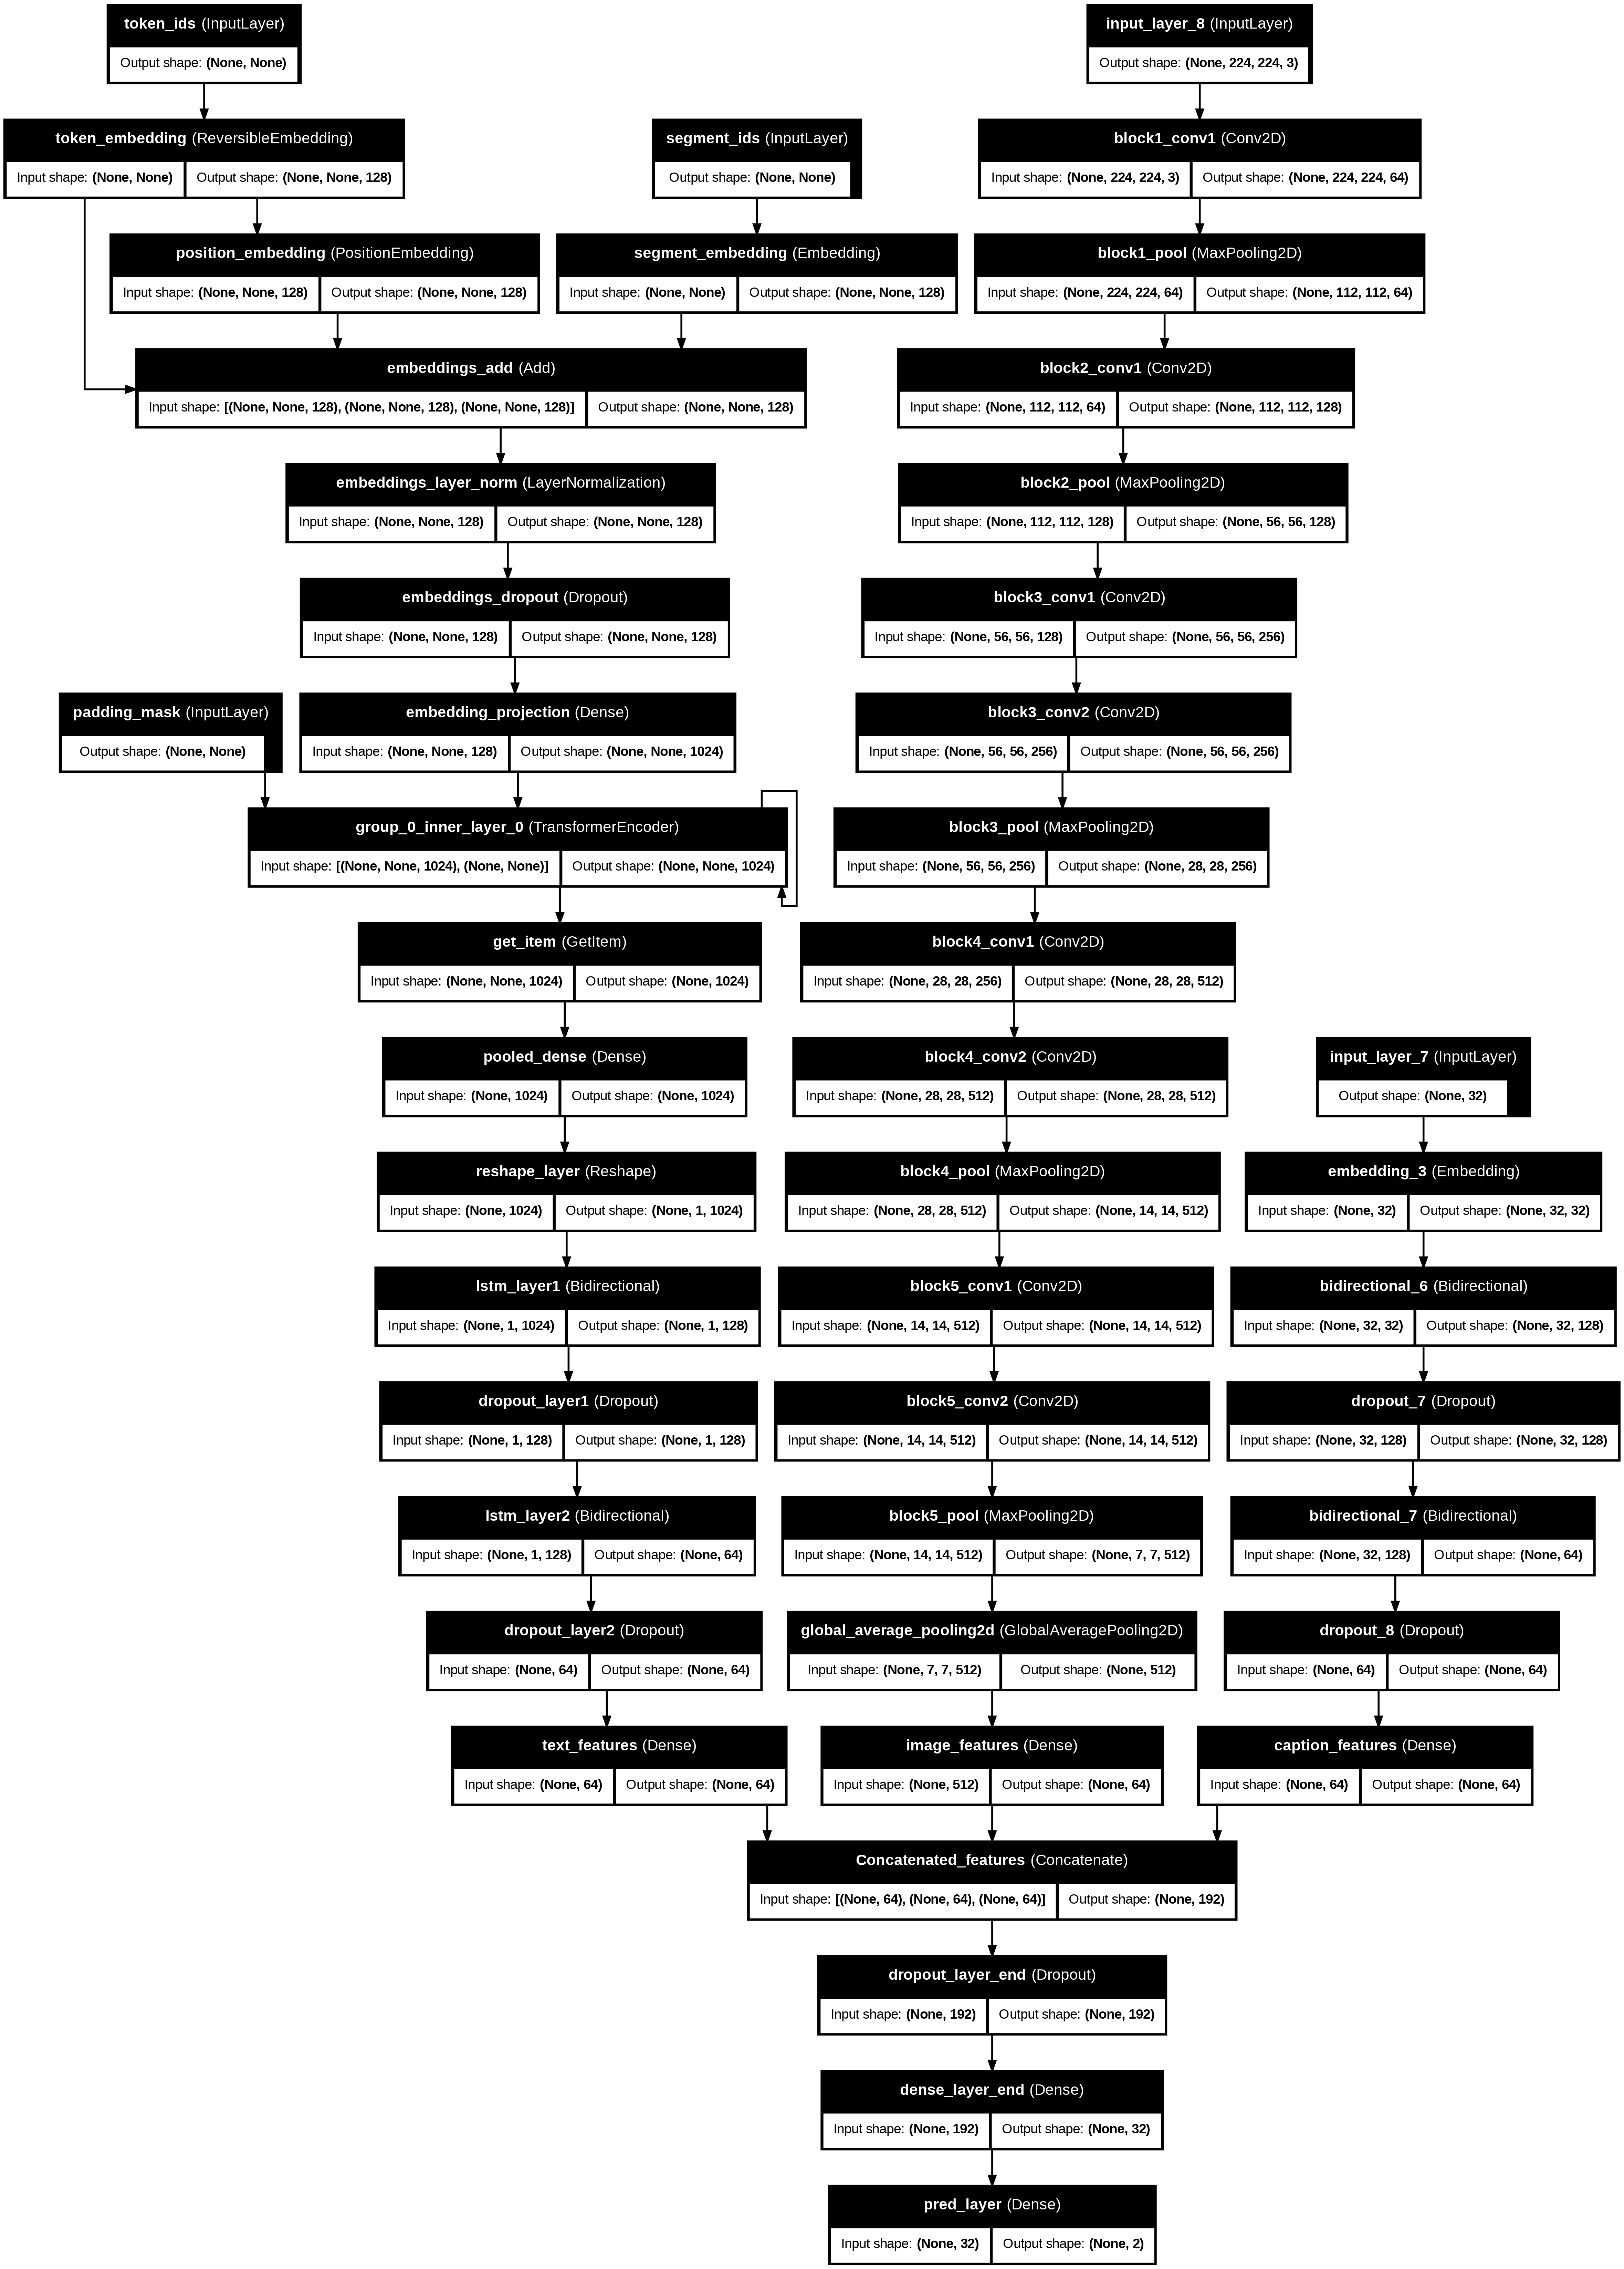

In [71]:
from keras.utils import plot_model
plot_model(model, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True,dpi=200)

In [72]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=["accuracy"]
             )

In [73]:
X_train_img = X_train_img.astype('float32')
X_test_img = X_test_img.astype('float32')


In [62]:
Y_test[:5]

0    1
1    1
2    1
3    0
4    0
Name: label, dtype: int64

In [61]:
# Should be float32 if you're using VGG's preprocessor
print(X_test_img.dtype)
print(X_train_img.dtype)

float32
float32


In [74]:
# Train the combined model
model.fit(
    x=[albert_preprocessor(X_train_txt), vgg11_preprocessor(X_train_img), preprocess_texts(train_cap)],
    y=Y_train,                      
    epochs=100,                      
    batch_size=32,
    shuffle=True,
    validation_data=([albert_preprocessor(X_test_txt), vgg11_preprocessor(X_test_img), preprocess_texts(test_cap)], Y_test)
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 487ms/step - accuracy: 0.5197 - loss: 0.7409 - val_accuracy: 0.4161 - val_loss: 0.8145
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.5746 - loss: 0.7040 - val_accuracy: 0.4832 - val_loss: 0.7613
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.6192 - loss: 0.6637 - val_accuracy: 0.4698 - val_loss: 0.7938
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.6593 - loss: 0.6390 - val_accuracy: 0.5302 - val_loss: 0.7554
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.6929 - loss: 0.5910 - val_accuracy: 0.4966 - val_loss: 0.7930
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.7284 - loss: 0.5675 - val_accuracy: 0.5034 - val_loss: 0.8253
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.7799 - loss: 0.5143 - val_accuracy: 0.5101 - val_loss: 0.9399
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.8185 - loss: 0.3911 - 

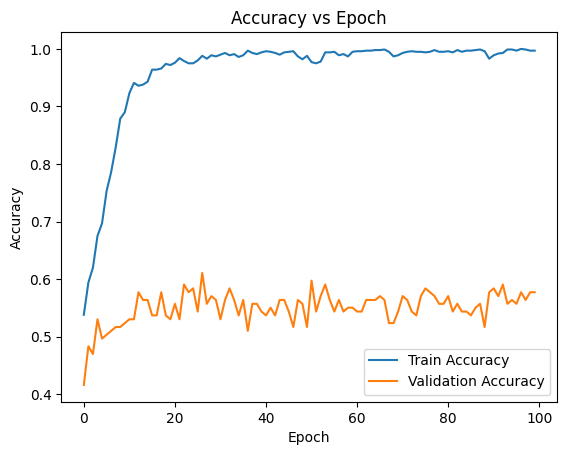

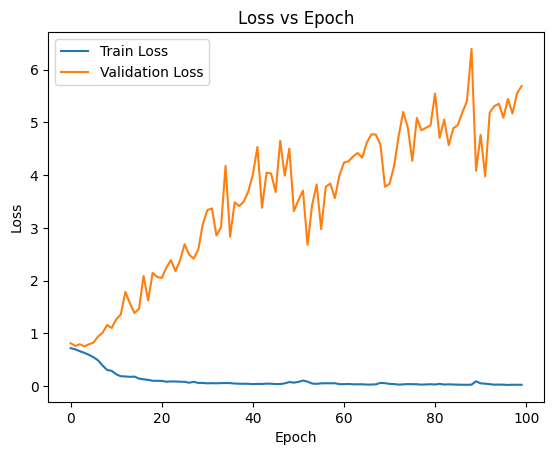

In [75]:
# Plot accuracy vs epoch
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss vs epoch
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [76]:
predictions = model.predict([albert_preprocessor(X_test_txt), vgg11_preprocessor(X_test_img), preprocess_texts(test_cap)])

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 


In [82]:
y_pred = np.argmax(predictions, axis=1)
y_test = Y_test

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [83]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted') 

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted') 

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='weighted') 

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# classification report for detailed metrics per class
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(2)]))

Accuracy: 0.4832
Precision: 0.5027
Recall: 0.4832
F1 Score: 0.4894

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.51      0.54        91
           1       0.37      0.45      0.40        58

    accuracy                           0.48       149
   macro avg       0.48      0.48      0.47       149
weighted avg       0.50      0.48      0.49       149



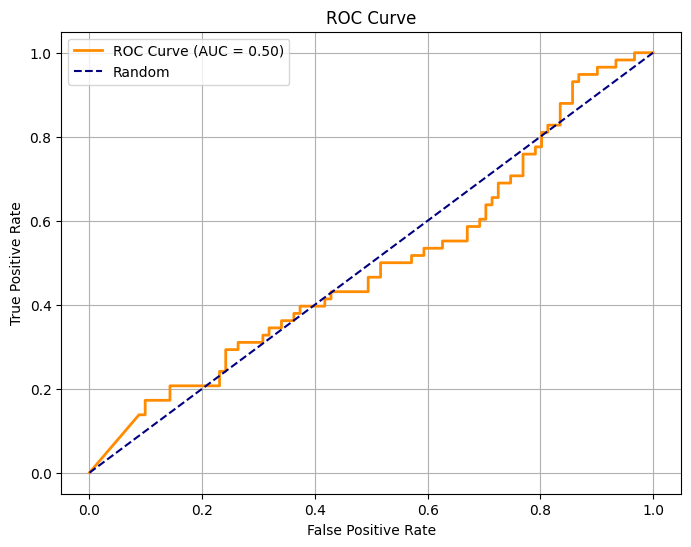

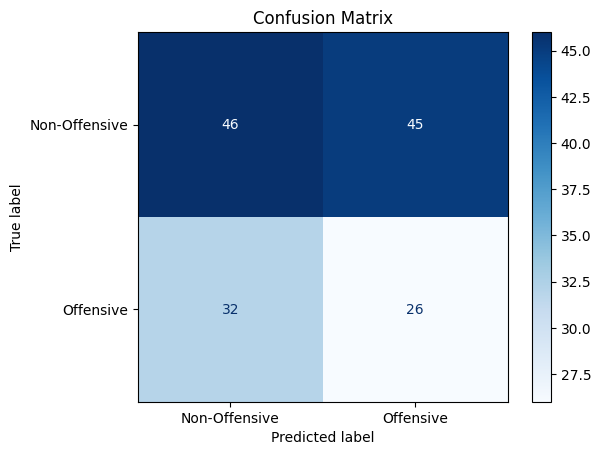

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_scores = predictions[:, 1]                
y_pred_labels = y_pred  

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot and Save ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
roc_path = "/kaggle/working/roc_curve_pre_fine_tune_multioff.png"
plt.savefig(roc_path, dpi=300)
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Offensive", "Offensive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
cf_path = "/kaggle/working/confusion_matrix_pre_fine_tune_multioff.png"
plt.savefig(cf_path, dpi=300)
plt.show()


In [93]:
# Fine tuning 
albert.backbone.trainable = True
for layer in vgg11.backbone.layers:
    layer.trainable = True

In [94]:
model.fit(
    x=[albert_preprocessor(X_train_txt), vgg11_preprocessor(X_train_img), preprocess_texts(train_cap)],
    y=Y_train,                      
    epochs=100,                      
    batch_size=32,
    shuffle=True,
    validation_data=([albert_preprocessor(X_test_txt), vgg11_preprocessor(X_test_img), preprocess_texts(test_cap)], Y_test)
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.7857 - loss: 1.5010 - val_accuracy: 0.5705 - val_loss: 0.8181
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.8549 - loss: 0.3364 - val_accuracy: 0.6040 - val_loss: 0.8871
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.9052 - loss: 0.2648 - val_accuracy: 0.6107 - val_loss: 1.0928
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.9434 - loss: 0.1949 - val_accuracy: 0.6107 - val_loss: 1.1922
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.9448 - loss: 0.1642 - val_accuracy: 0.6174 - val_loss: 1.2040
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.9600 - loss: 0.1221 - val_accuracy: 0.5638 - val_loss: 1.5037
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.9848 - loss: 0.0817 - val_accuracy: 0.6174 - val_loss: 1.5531
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.9800 - loss: 0.0928 - 

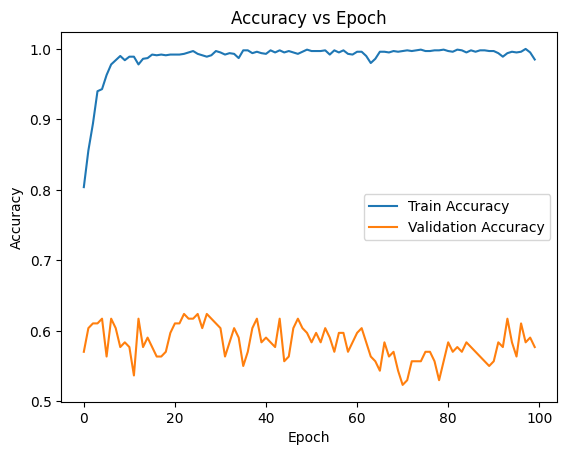

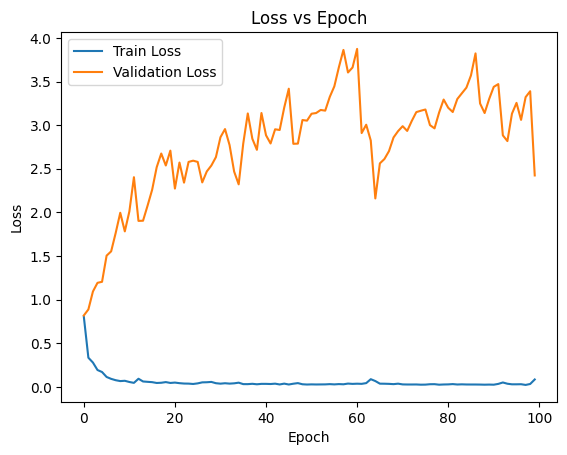

In [95]:
# Plot accuracy vs epoch
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss vs epoch
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [96]:
predictions = model.predict([albert_preprocessor(X_test_txt), vgg11_preprocessor(X_test_img), preprocess_texts(test_cap)])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


In [97]:
y_pred = np.argmax(predictions, axis=1)
y_test = Y_test

In [98]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted') 

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted') 

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='weighted') 

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# classification report for detailed metrics per class
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(2)]))

Accuracy: 0.5436
Precision: 0.5673
Recall: 0.5436
F1 Score: 0.5493

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.54      0.59        91
           1       0.43      0.55      0.48        58

    accuracy                           0.54       149
   macro avg       0.54      0.55      0.54       149
weighted avg       0.57      0.54      0.55       149



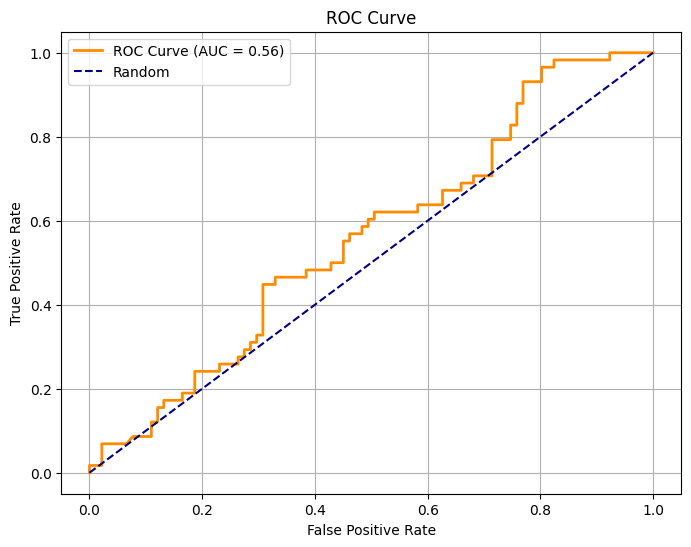

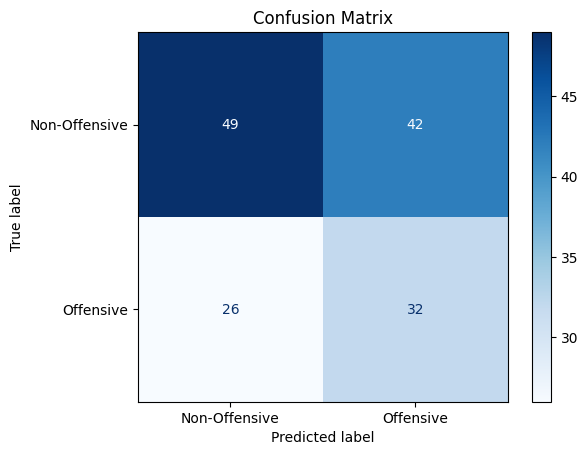

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_scores = predictions[:, 1]                
y_pred_labels = y_pred  

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot and Save ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
roc_path = "/kaggle/working/roc_curve_post_fine_tune_multioff.png"
plt.savefig(roc_path, dpi=300)
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Offensive", "Offensive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
cf_path = "/kaggle/working/confusion_matrix_post_fine_tune_multioff.png"
plt.savefig(cf_path, dpi=300)
plt.show()


In [ ]:
model.fit(
    x=[albert_preprocessor(X_train_txt), vgg11_preprocessor(X_train_img), preprocess_texts(train_cap)],
    y=Y_train,                      
    epochs=100,                      
    batch_size=16,
    shuffle=True,
    validation_data=([albert_preprocessor(X_test_txt), vgg11_preprocessor(X_test_img), preprocess_texts(test_cap)], Y_test)
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.8266 - loss: 0.6084 - val_accuracy: 0.5503 - val_loss: 1.0404
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.8865 - loss: 0.2601 - val_accuracy: 0.5235 - val_loss: 1.1210
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.8973 - loss: 0.2453 - val_accuracy: 0.5839 - val_loss: 1.3051
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9282 - loss: 0.1899 - val_accuracy: 0.5034 - val_loss: 1.9550
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9475 - loss: 0.1632 - val_accuracy: 0.5638 - val_loss: 1.5568
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9459 - loss: 0.1543 - val_accuracy: 0.5436 - val_loss: 1.7095
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9758 - loss: 0.0994 - val_accuracy: 0.5570 - val_loss: 2.0171
Epoch 8/100
41/63 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9768 - loss: 0.0785